1. Check whether decoding latent vectors that are drawn from the prior distribution yields reasonable sequences.
2. Check whether we can accurately reconstruct sequences after encoding them (i.e. encode sequence, then decode back, then check whether we get something close to what we started with)

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from Bio import SeqIO
from collections import Counter
import re
import logomaker # for plotting sequences of distributions over amino acids 
import pandas as pd
from autoencoder.modules.model import VAE
# help(VAE)
# help(MSA_Dataset)

In [6]:
MSA_id = "COG28-l100-s1.0-aNone"
data_path = f"msas/coupling_sims/processed/1250/{MSA_id}"

Load binarized MSA

In [7]:
## read multiple sequence alignment in binary representation
if MSA_id == "pevae":
    with open(f"{data_path}/msa_leaf_binary.pkl", 'rb') as file_handle:
        msa_binary = torch.tensor(pickle.load(file_handle))
else: 
    with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
        msa_binary = torch.tensor(pickle.load(file_handle))
# for some reason, msa_binary is float64 so first transform it to float 32 for later use
msa_binary = msa_binary.to(torch.float32)
# Number of sequences
n_total = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([1233, 100, 21])

Load sequence labels

If we are dealing with the family from Detlefsen, aka PF00144, we have a file with the phyla of the species from which these protiens are obtained that we'll want to load too in order to visualize the preservation of phylogeny by the embeddings:

In [8]:
if MSA_id == "PF00144":
    # get seq names
    with open(f"{data_path}/seq_names.pkl", 'rb') as file_handle:
        seq_names = pickle.load(file_handle)
    # each sequence has phylum labelled in the following file
    labelled_seq_fn = "data/Ding/raw/PF00144_full_length_sequences_labeled.fasta"
    phyla = {}
    with open(labelled_seq_fn, 'r') as file_handle:
        for record in SeqIO.parse(file_handle, "fasta"):
            label = record.id
            phylum = re.search(r'\[([^\]]+)\]', record.description).group(1)
            phyla[label] = phylum
    # order the phyla labels according to the order of sequences in our processed MSA (i.e. according to seq_names)
    ordered_msa_phyla = []
    for label in seq_names:
        label = label.split("/")[0]
        if label in phyla:
            ordered_msa_phyla.append(phyla[label])
        else:
            ordered_msa_phyla.append("Unknown")
    # Count the number of sequences in each phylum
    count = Counter(ordered_msa_phyla)
    sorted_count = sorted(count.items(), key=lambda item: item[1], reverse=True)
    for phylum, count in sorted_count:
        print(f"{phylum}: {count}")

Load model

In [9]:
model_path = "saved_models/coupling_sims/1250/COG28-l100-s1.0-aNone/model_layers100_ld2_wd0.01_epoch100_2025-01-10.pt"
layers_match = re.search(r'layers(\d+(\-\d+)*)', model_path)
num_hidden_units = [int(size) for size in layers_match.group(1).split('-')]
model = VAE(nl = nl, nc = nc, num_hidden_units=num_hidden_units, dim_latent_vars=2) # initiate to have the right architecture for loading
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Load mapping between integers and amino acid characters

In [10]:
if MSA_id == "pevae":    
    with open(f"{data_path}/LG_matrix.pkl", 'rb') as file_handle:
        LG_matrix = pickle.load(file_handle)
    amino_acids = LG_matrix['amino_acids']
else:
    amino_acids = ['R', 'H', 'K',
      'D', 'E',
      'S', 'T', 'N', 'Q',
      'C', 'G', 'P',
      'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W']
aa2idx = {}
aa2idx['.'] = 0
for i in range(len(amino_acids)):
    aa2idx[amino_acids[i]] = i + 1
idx_to_aa_dict = {v: k for k, v in aa2idx.items()}
idx_to_aa_dict    

{0: '.',
 1: 'R',
 2: 'H',
 3: 'K',
 4: 'D',
 5: 'E',
 6: 'S',
 7: 'T',
 8: 'N',
 9: 'Q',
 10: 'C',
 11: 'G',
 12: 'P',
 13: 'A',
 14: 'V',
 15: 'I',
 16: 'L',
 17: 'M',
 18: 'F',
 19: 'Y',
 20: 'W'}

# Part 1: Decoding draws from the prior

In [11]:
# draws from the prior to be decoded
# z has to be a torch.tensor with a size of (num_seqs, dim_latent_space)
num_seqs = n_total
dim_latent_space = model.dim_latent_vars
z = torch.randn(num_seqs, dim_latent_space)

# decode to amino acid probabilities
with torch.no_grad():
    log_p = model.decoder(z)
p = torch.exp(log_p)
p = p.numpy()
p.shape

(1233, 100, 21)

Plot the marginal distribution of each position in the sequences generated from the VAE prior

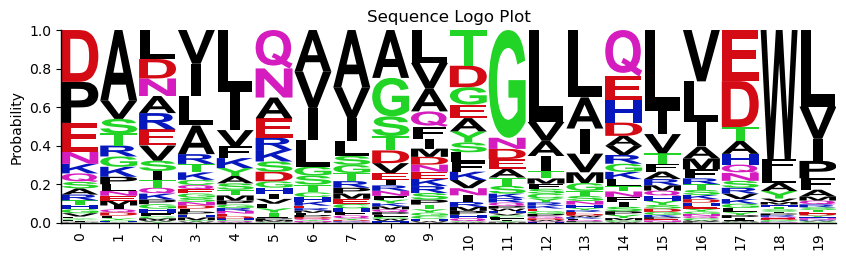

In [12]:
# Calculate averave probability at each position
p_ave = p.mean(axis=0)

# Remove the first column (gap character probabilities) and renormalize
p_ave_excl_gap = p_ave[:, 1:]
p_ave_excl_gap /= p_ave_excl_gap.sum(axis=1, keepdims=True)

# Only look at first and last 10 positions for ease of presentation
p_ave_excl_gap_tails = np.concatenate((p_ave_excl_gap[:10], p_ave_excl_gap[-10:]), axis=0)

# Convert p_ave to a pandas DataFrame
p_ave_excl_gap_tails_df = pd.DataFrame(p_ave_excl_gap_tails, columns=[idx_to_aa_dict[i] for i in range(1, nc)])

# Create the sequence logo plot
logo = logomaker.Logo(p_ave_excl_gap_tails_df, shade_below=.5, fade_below=.5, font_name='Arial')

# Set the plot title and labels
logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.style_xticks(rotation=90, fmt='%d', anchor=0)
logo.ax.set_ylabel('Probability')
logo.ax.set_title('Sequence Logo Plot')
plt.show()

Obtain the predicted amino acids generated under the prior (argmax over probability distribution)

In [13]:
prior_seqs_int = np.argmax(p, -1)
prior_seqs = []
for i in range(num_seqs):
    seq = [idx_to_aa_dict[idx] for idx in prior_seqs_int[i,:]]
    prior_seqs.append("".join(seq))
#prior_seqs[::10] # print every 10 sequences to compare with real sequences

Obtain the frequencies of pairs of amino acids across pairs of positions in the sequences generated from the VAE prior

In [57]:
from sklearn.metrics import mutual_info_score

def pair_counts(msa_int):
    """
    Creates a rank 4 tensor counts where counts[i,j,:,:] is a contingency table describing 
    the joint distribution of the pair of amino acids at positions i and j in the MSA 
    """
    counts = np.zeros((nl, nl, 20, 20), dtype=float)
    for seq in msa_int:
        for i in range(len(seq)):
            for j in range(i + 1, len(seq)):
                if seq[i] == 0 or seq[j] == 0: # don't include in count if either position is a gap character
                    continue
                else:
                    counts[i, j, seq[i]-1, seq[j]-1] += 1 
    #note that the (i, j, a, b) entry should equal the (j, i, b, a) entry 
    counts += np.transpose(counts, (1, 0, 3, 2))
    return counts

def normalize_to_freqs(pair_counts):
    non_gaps = np.sum(pair_counts, (2, 3), keepdims = True)
    non_gaps += np.eye(nl)[:, :, None, None] #avoids division by 0
    #print(non_gaps[:, :, 0, 0])
    return pair_counts / non_gaps

def get_mut_info(pair_counts):
    mut_info = np.zeros((nl, nl), dtype=float)
    for i in range(nl - 1):
        for j in range(i + 1, nl):
            mut_info[i, j] = mutual_info_score(None, None, contingency=pair_counts[i, j, :, :])
    return mut_info
prior_pcs = pair_counts(prior_seqs_int)
prior_freqs = normalize_to_freqs(prior_pcs)
prior_mut_info = get_mut_info(prior_pcs)

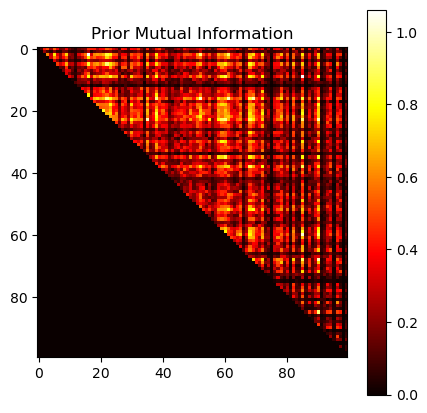

In [61]:
# plot 
plt.figure(figsize=(5, 5))
plt.imshow(prior_mut_info, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Prior Mutual Information")
plt.show()


Now let's compare to some real sequences. 

To do so, first let's retrieve an integer encoded version of the MSA (instead of binary). We have pickled such an encoding with file name `seq_msa.pkl`

In [62]:
if MSA_id == "pevae":
    with open(f"{data_path}/msa_leaf_nume.pkl", 'rb') as file_handle:
        real_seqs_int = pickle.load(file_handle)
else:
    with open(f"{data_path}/seq_msa_int.pkl", 'rb') as file_handle:
        real_seqs_int = pickle.load(file_handle)
# Alternatively, since `argmax` works for extracting position of the 1 from the one hot encoded vectors:
real_seqs_int2 = torch.argmax(msa_binary, -1)
assert torch.tensor(real_seqs_int).equal(real_seqs_int2)
print(real_seqs_int.shape)

(1233, 100)


Now we can decode the integers to amino acid characters using `idx_to_aa_dict`.

In [63]:
real_seqs = []
for i in range(num_seqs):
    seq = [idx_to_aa_dict[idx] for idx in real_seqs_int[i,:]]
    real_seqs.append("".join(seq))

Plot the marginal distribution of each position in the real sequences

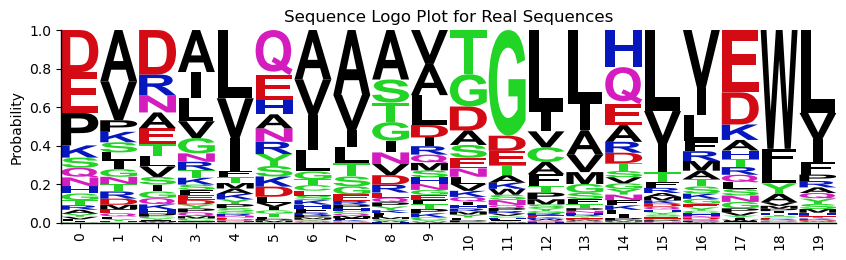

In [64]:
# Calculate the average probability distribution for each position in the real sequences
real_p_ave = np.zeros((nl, nc))
for seq in real_seqs_int:
    for i, aa in enumerate(seq):
        real_p_ave[i, aa] += 1
real_p_ave /= len(real_seqs_int)

# Remove the first column (gap character probabilities) and renormalize
real_p_ave_excl_gap = real_p_ave[:, 1:]
real_p_ave_excl_gap /= real_p_ave_excl_gap.sum(axis=1, keepdims=True)

# Only look at first and last 10 positions for ease of presentation
real_p_ave_excl_gap_tails = np.concatenate((real_p_ave_excl_gap[:10], real_p_ave_excl_gap[-10:]), axis=0)

# Convert real_p_ave to a pandas DataFrame
real_p_ave_excl_gap_tails_df = pd.DataFrame(real_p_ave_excl_gap_tails, columns=[idx_to_aa_dict[i] for i in range(1, nc)])

# Create the sequence logo plot for real sequences
real_logo = logomaker.Logo(real_p_ave_excl_gap_tails_df, shade_below=.5, fade_below=.5, font_name='Arial')

# Set the plot title and labels
real_logo.style_spines(visible=False)
real_logo.style_spines(spines=['left', 'bottom'], visible=True)
real_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
real_logo.ax.set_ylabel('Probability')
real_logo.ax.set_title('Sequence Logo Plot for Real Sequences')
plt.show()

Obtain the frequencies of pairs of amino acids across pairs of positions in the real sequences

In [66]:
real_pcs = pair_counts(real_seqs_int)
real_freqs = normalize_to_freqs(real_pcs)
real_mut_info = get_mut_info(real_pcs)

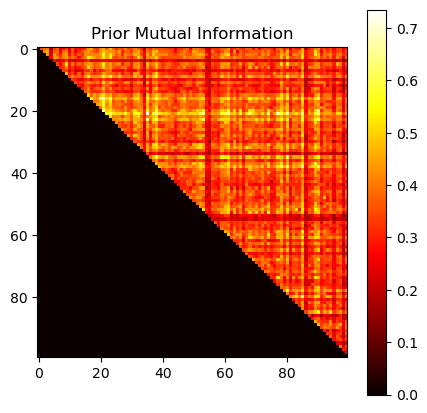

In [67]:
# plot 
plt.figure(figsize=(5, 5))
plt.imshow(real_mut_info, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Prior Mutual Information")
plt.show()

Scatter plot of amino acid probabilities in draws from prior against amino acid probabilities in real sequences

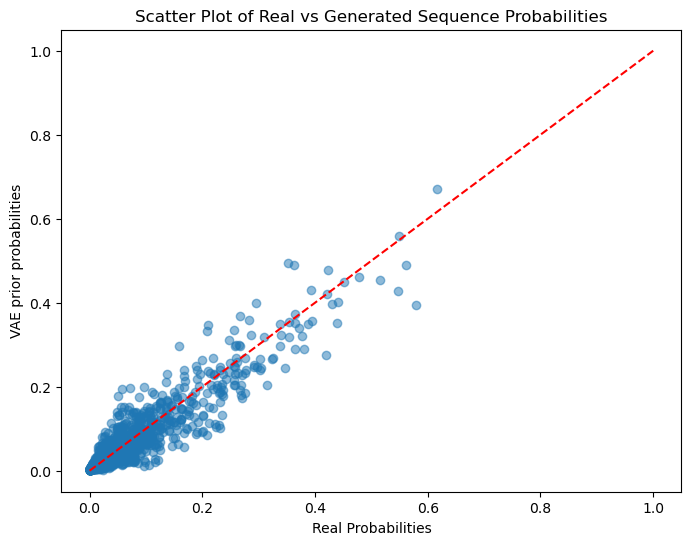

In [ ]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(real_p_ave_excl_gap, p_ave_excl_gap, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Real Probabilities')
plt.ylabel('VAE prior probabilities')
plt.title('Scatter Plot of Real vs Generated Sequence Probabilities')
plt.show()

Plot mutual informations from VAE prior model against real mutual informations

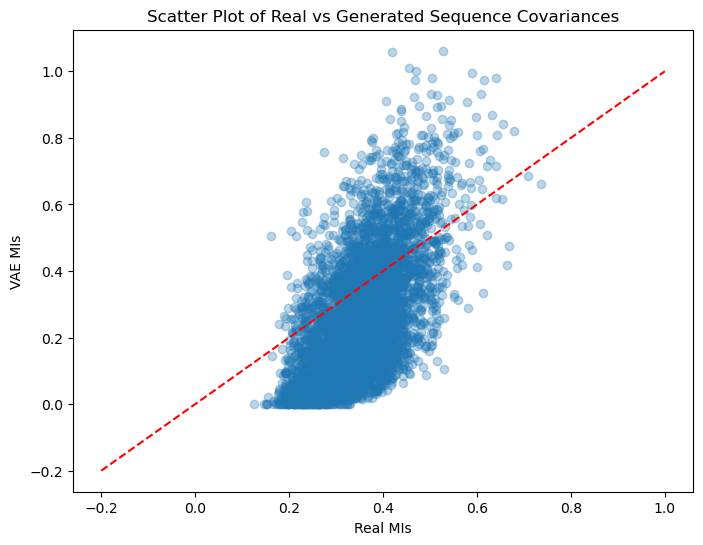

In [100]:
def plot_mi(mi1, mi2):
    """
    mi1 and mi2 should both be nl by nl numpy arrays
    """
    # Extract upper triangular elements
    upper_tri_indices = np.triu_indices_from(mi1, k=1)
    mi1_upper = mi1[upper_tri_indices]
    mi2_upper = mi2[upper_tri_indices]

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(mi1_upper, mi2_upper, alpha=0.3)
    plt.plot([-.2, 1], [-.2, 1], color='red', linestyle='--')
    plt.xlabel('Real MIs')
    plt.ylabel('VAE MIs')
    plt.title('Scatter Plot of Real vs Generated Sequence Covariances')
    plt.show()

plot_mi(real_mut_info, prior_mut_info)

What's the proportion of characters that match?

In [ ]:
# correct = 0
# total = 0
# for (seq, real_seq) in zip(seqs, real_seqs[:num_seqs]):
#   correct += sum([real_c == recon_c for (real_c, recon_c) in zip(seq, real_seq)])
#   total += len(seq)
# print(f"correct: {correct}")
# print(f"total: {total}")
# print(f"Percentage correct: {np.round(100*correct/total, 2)}")

What's the distribution of percentage of accurately predicted aa's across sequences?

In [ ]:
# acc = []
# for (predicted_seq, real_seq) in zip(seqs, real_seqs):
#   n_correct = sum([predicted_c == real_c for (predicted_c, real_c) in zip(predicted_seq, real_seq)])
#   acc.append(n_correct)

# acc = np.array(acc)/len(real_seqs[0])
# plt.hist(acc, bins=30)

# Part 2: Reconstructing sequences

Now let's not just draw from the prior and decode, but draw from the posterior defined by a given real sequence and then decode. In other words, let's see whether our VAE is good at reconstructing sequences:

First, we encode the real sequences

In [85]:
with torch.no_grad():
  mu, sigma = model.encoder(msa_binary)
mu.shape, sigma.shape

(torch.Size([1233, 2]), torch.Size([1233, 2]))

We can view the `mu` vectors as embeddings of the proteins. Moreover, for one of the families, we can color by the phylum of the species from which the sample is taken. Here's a function for plotting for this family

In [86]:
def plot_colored_pf00144(embeddings, plot_top=True) -> None:
    """
    plot_top controls whether we plot the same phyla as detlefsen or the top 10 most common phyla
    """
    detlefsen_phyla_dict = {"Acidobacteria": "#693B9E", 
                        "Actinobacteria": "#FBCB90", 
                        "Bacteroidetes": "#E3181B",
                        "Chloroflexi": "#F3A19F", 
                        "Cyanobacteria": "#FA7F00", 
                        "Deinococcus-Thermus": "#A8CCE0", 
                        "Firmicutes": "#36A038", 
                        "Fusobacteria": "#B2E289", 
                        "Proteobacteria": "#147AB0"}
    colors = set(detlefsen_phyla_dict.values())
    top_phyla_list = [phylum for phylum, _ in sorted_count[:10] if phylum != "Other"]
    top_phyla_dict = {}
    # Assign the corresponding color to each phyla in the top_phyla_list as in detlefsen_phyla_dict
    for phylum in top_phyla_list:
        if phylum in detlefsen_phyla_dict:
            top_phyla_dict[phylum] = detlefsen_phyla_dict[phylum]
    # For the remaining phyla, assign a color that is not in the set of colors already used
    colors = list(colors - set(top_phyla_dict.values()) )
    for phylum in top_phyla_list:
        if phylum not in top_phyla_dict:
            top_phyla_dict[phylum] = colors.pop()
    phyla_dict = top_phyla_dict if plot_top else detlefsen_phyla_dict
    # Create a scatter plot
    plt.figure(figsize=(5, 4))
    for phylum in phyla_dict:
        idx = [i for i, ph in enumerate(ordered_msa_phyla) if ph == phylum]
        plt.scatter(mu[idx, 0], mu[idx, 1], s=6, label=phylum, c = phyla_dict[phylum])

    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('2D Embeddings Visualization')
    plt.legend()
    plt.show()

Now let's actually plot

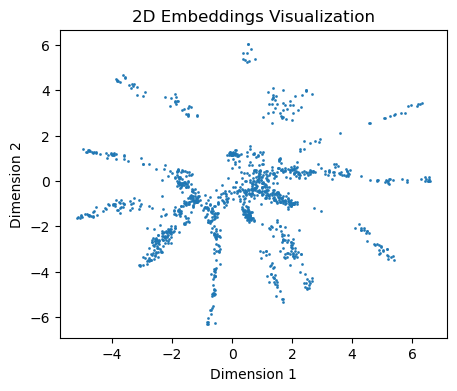

In [87]:
plt.figure(figsize=(5, 4))
plt.scatter(mu[:, 0], mu[:, 1], s=1, alpha=0.9)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings Visualization')
plt.show()
if MSA_id == "PF00144":
    plot_colored_pf00144(mu)

If the embeddings are in more than two dimensions, we can plot first two pca components

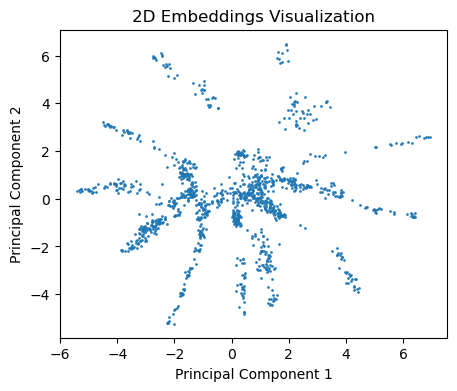

In [88]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mu_pca = pca.fit_transform(mu)
plt.figure(figsize=(5, 4))
plt.scatter(mu_pca[:, 0], mu_pca[:, 1], s=1, alpha=0.9)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Embeddings Visualization')
plt.show()
if MSA_id == "PF00144":
    plot_colored_pf00144(mu_pca)


Now we decode the $\mu$'s

In [89]:
with torch.no_grad():
  log_p = model.decoder(mu)
  p = torch.exp(log_p)
p.shape

torch.Size([1233, 100, 21])

Now we covert probablities into actual protein sequences by choosing the most likely amino acid at each position.


In [90]:
vae_seqs_int = torch.argmax(p, -1)

To check accuracy, i.e. the percentage of amino acids that match, we can simply run

In [91]:
# Proportion of amino acids correctly recovered
real_seqs_int = torch.tensor(real_seqs_int)
torch.sum(real_seqs_int == vae_seqs_int)/real_seqs_int.nelement()

/var/folders/7p/yq6kkwrd1772f69hv0wx14y40000gn/T/ipykernel_7969/1439174338.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_seqs_int = torch.tensor(real_seqs_int)


tensor(0.5203)

What do the mutual infos of our reconstructed sequences look like?

In [93]:
vae_seqs_int = vae_seqs_int.numpy()
recon_pcs = pair_counts(vae_seqs_int)
recon_freqs = normalize_to_freqs(recon_pcs)
recon_mut_info = get_mut_info(recon_pcs)

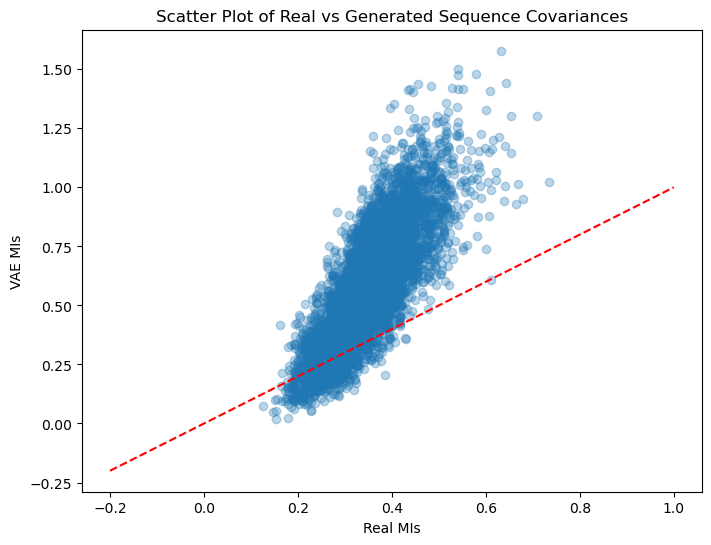

In [101]:
plot_mi(real_mut_info, recon_mut_info)

Alternative method to compute accuracy of our reconstructions:

In [98]:
recon_seqs = []
for i in range(len(vae_seqs_int)):
    recon_seq = [idx_to_aa_dict[idx] for idx in vae_seqs_int[i,:]]
    recon_seqs.append("".join(recon_seq))
# print every 10 sequences to compare with real sequences
#print(recon_seqs[::10])
correct = 0
total = 0
for (recon_seq, real_seq) in zip(recon_seqs, real_seqs):
  correct += sum([real_c == recon_c for (real_c, recon_c) in zip(recon_seq, real_seq)])
  total += len(real_seq)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")

correct: 64152
total: 123300
Percentage correct: 52.03


What's the distribution of accuracy across sequences?

(array([ 4.,  4., 15., 20., 23., 56., 69., 59., 43., 53., 71., 45., 37.,
        71., 85., 87., 81., 40., 56., 72., 38., 14., 32., 24., 46., 29.,
        29., 20.,  7.,  3.]),
 array([0.12      , 0.14766667, 0.17533333, 0.203     , 0.23066667,
        0.25833333, 0.286     , 0.31366667, 0.34133333, 0.369     ,
        0.39666667, 0.42433333, 0.452     , 0.47966667, 0.50733333,
        0.535     , 0.56266667, 0.59033333, 0.618     , 0.64566667,
        0.67333333, 0.701     , 0.72866667, 0.75633333, 0.784     ,
        0.81166667, 0.83933333, 0.867     , 0.89466667, 0.92233333,
        0.95      ]),
 <BarContainer object of 30 artists>)

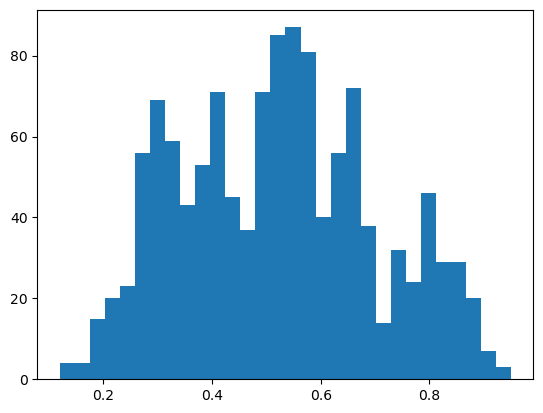

In [99]:
acc = []
for (recon_seq, real_seq) in zip(recon_seqs, real_seqs):
  n_correct = sum([real_c == recon_c for (real_c, recon_c) in zip(recon_seq, real_seq)])
  acc.append(n_correct)

acc = np.array(acc)/len(real_seqs[0])
plt.hist(acc, bins=30)